# Road Segmentation

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import cv2

import os

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.metrics import MeanIoU, Accuracy

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# import numpy as np

# def extract_padded_patches(image, patch_size=(512, 512)):
#     height, width = image.shape[:2]
#     patch_height, patch_width = patch_size

#     num_patches_y = (height + patch_height - 1) // patch_height
#     num_patches_x = (width + patch_width - 1) // patch_width

#     # Calculate padding
#     pad_y = num_patches_y * patch_height - height
#     pad_x = num_patches_x * patch_width - width

#     # Pad the image
#     padded_image = np.pad(image, ((0, pad_y), (0, pad_x), (0, 0)), mode='constant')
#     #print(padded_image.shape)
    
#     # Extract patches
#     patches = []

#     for y in range(0, num_patches_y * patch_height, patch_height):
#         for x in range(0, num_patches_x * patch_width, patch_width):
#             patch = padded_image[y:y+patch_height, x:x+patch_width]
#             #plt.imshow(patch/255)
#             patches.append(patch)

#     return np.array(patches)

# #load the .npz file
# def load_images(path,name, labels):
#     npzfile=np.load(path+"{}.npz".format(name))
#     images=npzfile['arr_0']
#     #patches_image=np.zeros()
#     images =[extract_padded_patches(image, (512, 512)) for image in images]
#     images = [patch for patches in images for patch in patches]


#     npzfile=np.load(path+"{}.npz".format(labels))
#     labels=npzfile['arr_0']
#     #labels=[color.rgb2gray(resize(x,(512,512),mode='constant', preserve_range=True)) for x in labels]
    
#     labels =[extract_padded_patches(image, (512, 512)) for image in labels]
#     labels = [patch for patches in labels for patch in patches]
#     labels = np.array(labels)
#     labels=[cv2.threshold(color.rgb2gray(gt), 128, 1, cv2.THRESH_BINARY)[1] for gt in labels]
    
#     return np.array(images),  np.reshape(np.array(labels), (-1, 512, 512, 1))

In [5]:
# import matplotlib.pyplot as plt

# # Assume 'patches' is a list of images obtained from extract_padded_patches function

# # Create a figure with subplots
# fig, axs = plt.subplots(1, len(patches), figsize=(15, 5))

# # Iterate through patches and display them
# for i, patch in enumerate(patches):
#     axs[i].imshow(patch/255)
#     axs[i].axis('off')
#     axs[i].set_title(f'Patch {i + 1}')

# # Show the plot
# plt.show()


In [6]:
#load the .npz file
def load_images(path, name, labels):
    npzfile=np.load(path+"{}.npz".format(name))
    images=npzfile['arr_0']


    npzfile=np.load(path+"{}.npz".format(labels))
    labels=npzfile['arr_0']

    return images, labels

In [7]:
path='E:\\Pavithra\\road\\'

x_train,y_train = load_images(path,'train_new_images_patches_300','train_labels_new_patches_300')


x_val,y_val = load_images(path,'val_images_patches','val_labels_patches')


x_test,y_test = load_images(path,'test_images_patches','test_labels_patches')


x_train.sort()
y_train.sort()

x_val.sort()
y_val.sort()

x_test.sort()
y_test.sort()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2700, 512, 512, 3) (2700, 512, 512, 1) (441, 512, 512, 3) (441, 512, 512, 1)


In [8]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(2700, 512, 512, 3) (2700, 512, 512, 1) (126, 512, 512, 3) (126, 512, 512, 1) (441, 512, 512, 3) (441, 512, 512, 1)


In [9]:
from tensorflow.keras.utils import Sequence
import numpy as np 
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(x_train, y_train, 1)
val_gen = DataGenerator(x_val, y_val, 1)


Text(0.5, 1.0, 'Actual image')

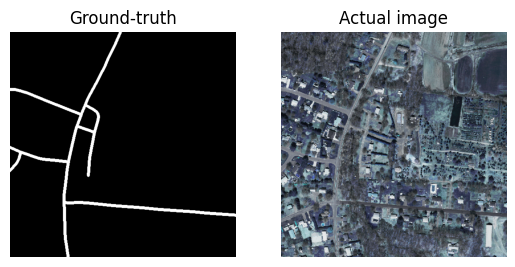

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.figsize = (30,30)

ax = fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y_train[1]/255,(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax = fig.add_subplot(1,2,2)
ax.imshow(x_train[1]/255)
plt.axis('off')
plt.title("Actual image")

# Loss

In [11]:
def precision(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    precision = (tp + smooth) / (tp + fp + smooth)
    return precision


def recall(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    recall = (tp + smooth) / (tp + fn + smooth)
    return recall


In [12]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [13]:
import tensorflow as tf

def create_callbacks():
    # Reduce learning rate on plateau
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.5,
        patience=2,
        verbose=1,
        cooldown=1,
        min_delta=0.0001
    )

    # Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=3,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )

    # Model checkpoint
    # Define the path using os.path.join for cross-platform compatibility
    check_path = os.path.join('.', 'morphUnet_road.h5')
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        check_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )

    return [reduce_lr, early_stop, checkpoint]

# Usage example:


In [14]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Accuracy plot
    plt.plot(history['accuracy'], label='train_acc')
    plt.plot(history['val_accuracy'], '--', label='val_acc')
    plt.legend()
    plt.xlabel("No. of epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.show()

    # Loss plot
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], '--', label='val_loss')
    plt.legend()
    plt.xlabel("No. of epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.show()



In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, precision_score, recall_score

def get_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true**2, axis=(0, 1, 2)) + np.sum(y_pred**2, axis=(0, 1, 2))
    dc = 2 * intersection / union
    return dc


def evaluate_segmentation(y_test, y_pred):
    # Mean Intersection over Union
    mean_iou = MeanIoU(2)
    mean_iou.update_state(y_test, y_pred)
    class_iou = mean_iou.result().numpy()
    mean_iou.reset_states()
    
    # Accuracy
    acc = Accuracy()
    acc.update_state(y_test, y_pred)
    accuracy = acc.result().numpy()
    acc.reset_states()
    
    # Precision
    precision = precision_score(y_test.ravel(), y_pred.ravel(), average='binary')
    
    # Recall
    recall = recall_score(y_test.ravel(), y_pred.ravel(), average='binary')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test.ravel(), y_pred.ravel())
    
    # Classification Report
    cr = classification_report(y_test.ravel(), y_pred.ravel())
    
    # Cohen's Kappa Score
    kappa = cohen_kappa_score(y_test.ravel(), y_pred.ravel())
    
    # Dice Coefficient
    dice_coeff = get_dice(y_test, y_pred)
    mean_dice_coeff = np.mean(dice_coeff)
    
    return {
        "mean_iou": mean_iou,
        "class_iou": class_iou,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm,
        "classification_report": cr,
        "cohen_kappa_score": kappa,
        "dice_coefficient": dice_coeff,
        "mean_dice_coefficient": mean_dice_coeff
    }


In [16]:
import matplotlib.pyplot as plt

def visualize_predictions(x_test, y_test, y_pred, num_samples=10):
    fig = plt.figure(figsize=(20, 15))

    for i in range(num_samples):
        # Plot input image
        ax = fig.add_subplot(num_samples, 3, 3*i+1)
        ax.imshow(np.reshape(x_test[i]/255, (512, 512,3)))
        plt.axis('off')
        plt.title("Input image")

        # Plot ground truth
        ax = fig.add_subplot(num_samples, 3, 3*i+2)
        ax.imshow(np.reshape(y_test[i], (512, 512)), cmap="gray")
        plt.axis('off')
        plt.title("Ground-truth")

        # Plot predicted image
        ax = fig.add_subplot(num_samples, 3, 3*i+3)
        ax.imshow(np.reshape(y_pred[i], (512, 512)), cmap="gray")
        plt.axis('off')
        plt.title("Predicted image")

    plt.tight_layout()
    plt.show()

# **Dual Path Morph Unet**

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from keras import initializers, constraints
import tensorflow.keras.utils as conv_utils
from keras import backend as K


class Erosion2D(Layer):
    def __init__(
        self,
        num_filters,
        kernel_size,
        strides=(1, 1),
        padding="valid",
        kernel_initializer="glorot_uniform",
        kernel_constraint=None,
        **kwargs
    ):
        super(Erosion2D, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.channel_axis = -1

    def build(self, input_shape):
        if input_shape[self.channel_axis] is None:
            raise ValueError(
                "The channel dimension of the inputs "
                "should be defined. Found `None`."
            )

        input_dim = input_shape[self.channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.num_filters)

        self.kernel = self.add_weight(
            shape=kernel_shape,
            initializer=self.kernel_initializer,
            name="kernel",
            constraint=self.kernel_constraint,
        )

        # Be sure to call this at the end
        super(Erosion2D, self).build(input_shape)

    def call(self, x):
        outputs = K.placeholder()
        for i in range(self.num_filters):
            # erosion2d returns image of same size as x
            # so taking min over channel_axis
            out = K.min(
                self.__erosion2d(x, self.kernel[..., i], self.strides, self.padding),
                axis=self.channel_axis,
                keepdims=True,
            )

            if i == 0:
                outputs = out
            else:
                outputs = K.concatenate([outputs, out])

        return outputs

    def compute_output_shape(self, input_shape):
        # if self.data_format == 'channels_last':
        space = input_shape[1:-1]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_utils.conv_output_length(
                space[i],
                self.kernel_size[i],
                padding=self.padding,
                stride=self.strides[i],
                dilation=1,
            )  # self.erosion_rate[i])
            new_space.append(new_dim)

        return (input_shape[0],) + tuple(new_space) + (self.num_filters,)

    def __erosion2d(self, x, st_element, strides, padding, rates=(1, 1, 1, 1)):
        # tf.nn.erosion2d(input, filter, strides, rates, padding, name=None)
        x = tf.compat.v1.nn.erosion2d(
            x, st_element, (1,) + strides + (1,), rates, padding.upper()
        )
        return x


class Dilation2D(Layer):
    """
    Dilation 2D Layer
    for now assuming channel last
    """

    def __init__(
        self,
        num_filters,
        kernel_size,
        strides=(1, 1),
        padding="valid",
        kernel_initializer="glorot_uniform",
        kernel_constraint=None,
        **kwargs
    ):
        super(Dilation2D, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_constraint = constraints.get(kernel_constraint)

        # for we are assuming channel last
        self.channel_axis = -1

        # self.output_dim = output_dim

    def build(self, input_shape):
        if input_shape[self.channel_axis] is None:
            raise ValueError(
                "The channel dimension of the inputs "
                "should be defined. Found `None`."
            )

        input_dim = input_shape[self.channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.num_filters)

        self.kernel = self.add_weight(
            shape=kernel_shape,
            initializer=self.kernel_initializer,
            name="kernel",
            constraint=self.kernel_constraint,
        )

        # Be sure to call this at the end
        super(Dilation2D, self).build(input_shape)

    def call(self, x):
        # outputs = K.placeholder()
        for i in range(self.num_filters):
            # dilation2d returns image of same size as x
            # so taking max over channel_axis
            out = K.max(
                self.__dilation2d(x, self.kernel[..., i], self.strides, self.padding),
                axis=self.channel_axis,
                keepdims=True,
            )

            if i == 0:
                outputs = out
            else:
                outputs = K.concatenate([outputs, out])

        return outputs

    def compute_output_shape(self, input_shape):
        # if self.data_format == 'channels_last':
        space = input_shape[1:-1]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_utils.conv_output_length(
                space[i],
                self.kernel_size[i],
                padding=self.padding,
                stride=self.strides[i],
                dilation=1,
            )  # self.dilation_rate[i])
            new_space.append(new_dim)

        return (input_shape[0],) + tuple(new_space) + (self.num_filters,)

    def __dilation2d(self, x, st_element, strides, padding, rates=(1, 1, 1, 1)):
        # tf.nn.dilation2d(input, filter, strides, rates, padding, name=None)
        x = tf.compat.v1.nn.dilation2d(
            x, st_element, (1,) + strides + (1,), rates, padding.upper()
        )
        return x




In [18]:
from tensorflow import keras
import keras
from keras.models import Model
from keras.layers import Input, Lambda, BatchNormalization, Conv2D, Activation
from keras.layers import add, dot, concatenate, Concatenate, AveragePooling2D, Conv2DTranspose


def _morph_unit(inputs, filters=4, kernel=(3, 3)):
    erosion = Erosion2D(
        filters, kernel, padding="same", strides=(1, 1), kernel_initializer="he_normal"
    )(inputs)
    dilation = Dilation2D(
        filters, kernel, padding="same", strides=(1, 1), kernel_initializer="he_normal"
    )(inputs)
    xc = Concatenate()([erosion, dilation])
    xc = Conv2D(
        2 * filters,
        kernel,
        padding="same",
        activation="linear",
        kernel_initializer="he_normal",
    )(xc)
    return xc


def _bn_relu_conv_block(inputs, filters, kernel=(3, 3), stride=(1, 1)):
    x = Conv2D(
        filters,
        kernel,
        padding="same",
        use_bias=False,
        kernel_initializer="he_normal",
        strides=stride,
    )(inputs)
    x = BatchNormalization(axis=-1)(x)
    x = Activation("relu")(x)
    return x


def _grouped_morph_block(input, grouped_channels, cardinality):
    group_morph_list = []
    for c in range(cardinality):
        x = Lambda(
            lambda z: z[:, :, :, c * grouped_channels : (c + 1) * grouped_channels]
        )(input)
        x = _morph_unit(x, grouped_channels)
        group_morph_list.append(x)
    merged_output = concatenate(group_morph_list, axis=-1)
    merged_output = BatchNormalization(axis=-1)(merged_output)
    return merged_output


def _dual_path_block(
    input,
    pointwise_filters_a,
    grouped_conv_filters_b,
    pointwise_filters_c,
    filter_increment,
    cardinality,
    block_type="normal",
):
    grouped_channels = int(grouped_conv_filters_b / cardinality)
    inputs = concatenate(input, axis=-1) if isinstance(input, list) else input
    stride = (1, 1)

    if block_type == "projection":
        projection = True
    elif block_type == "normal":
        projection = False
    else:
        raise ValueError('"block_type" must be either "projection" or "normal"')

    if projection:
        projection_path = _bn_relu_conv_block(
            inputs,
            filters=pointwise_filters_c + 2 * filter_increment,
            kernel=(1, 1),
            stride=stride,
        )
        input_residual_path = Lambda(lambda z: z[:, :, :, :pointwise_filters_c])(
            projection_path
        )
        input_dense_path = Lambda(lambda z: z[:, :, :, pointwise_filters_c:])(
            projection_path
        )
    else:
        input_residual_path = input[0]
        input_dense_path = input[1]

    x = _bn_relu_conv_block(inputs, filters=pointwise_filters_a, kernel=(1, 1))
    x = _grouped_morph_block(
        x, grouped_channels=grouped_channels, cardinality=cardinality
    )
    x = _bn_relu_conv_block(
        x, filters=pointwise_filters_c + filter_increment, kernel=(1, 1)
    )

    output_residual_path = Lambda(lambda z: z[:, :, :, :pointwise_filters_c])(x)
    output_dense_path = Lambda(lambda z: z[:, :, :, pointwise_filters_c:])(x)

    residual_path = add([input_residual_path, output_residual_path])
    dense_path = concatenate([input_dense_path, output_dense_path], axis=-1)
    return [residual_path, dense_path]


def _decoder_block(inputs, skip_connection, filters):
    upsampled_input = Conv2DTranspose(
        filters=int(inputs.shape[-1]), kernel_size=(3, 3), strides=(2, 2), padding="same"
    )(inputs)
    concatenated_output = Concatenate()([upsampled_input, skip_connection])
    concatenated_output = _morph_block(concatenated_output, filters)
    return concatenated_output


def _morph_block(inputs, num_filters, filter_increment=12, cardinality=6):
    x = inputs
    x = _dual_path_block(
        x,
        num_filters,
        num_filters,
        num_filters,
        filter_increment,
        cardinality,
        "projection",
    )
    x = _dual_path_block(
        x,
        num_filters,
        num_filters,
        num_filters,
        filter_increment,
        cardinality,
        "normal",
    )
    x = concatenate(x, axis=-1)
    return x


def DPM_UNet(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    morph_ip = _morph_unit(inputs, 6)

    E1 = _morph_block(morph_ip, 12)
    pool1 = AveragePooling2D(pool_size=(2, 2))(E1)

    E2 = _morph_block(pool1, 12 * 2)
    pool2 = AveragePooling2D(pool_size=(2, 2))(E2)

    E3 = _morph_block(pool2, 12 * 3)
    pool3 = AveragePooling2D(pool_size=(2, 2))(E3)

    C = _morph_block(pool3, 12 * 4)

    D3 = _decoder_block(C, E3, 12 * 3)
    D2 = _decoder_block(D3, E2, 12 * 2)
    D1 = _decoder_block(D2, E1, 12)

    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(D1)
    return Model(inputs, outputs)

In [19]:
model=DPM_UNet((512,512,3))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 erosion2d (Erosion2D)          (None, 512, 512, 6)  162         ['input_1[0][0]']                
                                                                                                  
 dilation2d (Dilation2D)        (None, 512, 512, 6)  162         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 512, 512, 12  0           ['erosion2d[0][0]',          

In [21]:
def dice(y_true, y_pred):
    smooth = 1.0
    y_true = K.cast(y_true, dtype='float32')  # Cast to float32
    y_pred = K.cast(y_pred, dtype='float32')  # Cast to float32
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_score = (2.0 * intersection + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )
    return dice_score

def dice_loss(y_true, y_pred):
    loss = 1 - dice(y_true, y_pred)
    return loss


In [22]:
opt = Adam(learning_rate=3e-4)
model.compile(optimizer=opt, loss=dice_loss, metrics=['accuracy', iou_coef,dice, precision, recall])

In [23]:
callbacks = create_callbacks()
history = model.fit(train_gen, validation_data=val_gen, batch_size=1,shuffle=True, verbose=1
                                  ,epochs = 10, callbacks = callbacks )

Epoch 1/10
2700/2700 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.9325 - iou_coef: 0.1941 - dice: 0.2949 - precision: 0.2803 - recall: 0.4937
Epoch 00001: val_loss improved from inf to 0.72492, saving model to .\morphUnet_road.h5
2700/2700 [==============================] - 3182s 1s/step - loss: 0.7051 - accuracy: 0.9325 - iou_coef: 0.1941 - dice: 0.2949 - precision: 0.2803 - recall: 0.4937 - val_loss: 0.7249 - val_accuracy: 0.9371 - val_iou_coef: 0.1796 - val_dice: 0.2751 - val_precision: 0.5116 - val_recall: 0.2358 - lr: 3.0000e-04
Epoch 2/10
2700/2700 [==============================] - ETA: 0s - loss: 0.6257 - accuracy: 0.9576 - iou_coef: 0.2607 - dice: 0.3743 - precision: 0.3743 - recall: 0.5210
Epoch 00002: val_loss improved from 0.72492 to 0.70050, saving model to .\morphUnet_road.h5
2700/2700 [==============================] - 3105s 1s/step - loss: 0.6257 - accuracy: 0.9576 - iou_coef: 0.2607 - dice: 0.3743 - precision: 0.3743 - recall: 0.5210 - val_lo

In [24]:
# Save the history object
np.save('training_history_morph_Unet.npy', history.history)

# Load the history object
loaded_history = np.load('training_history_morph_Unet.npy', allow_pickle='TRUE').item()

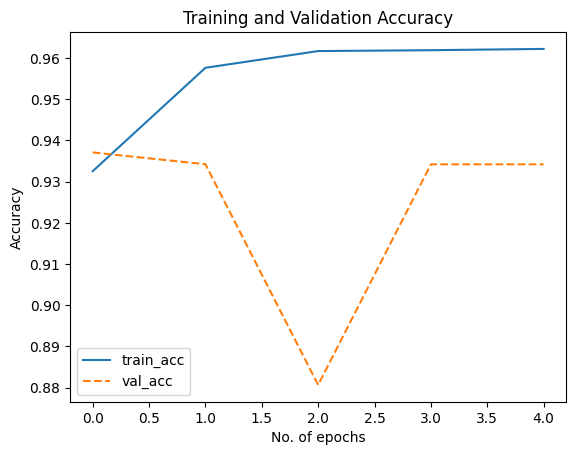

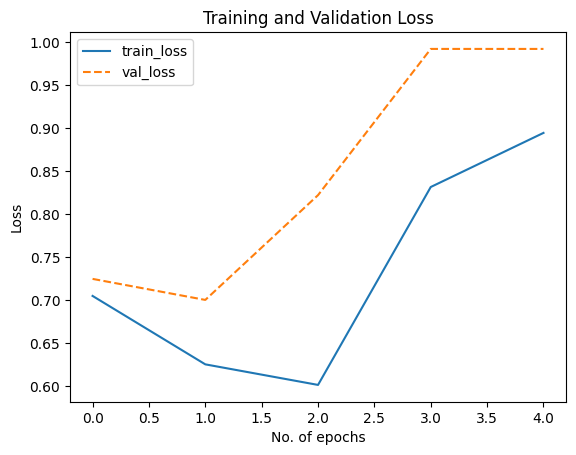

In [25]:
plot_history(loaded_history)

In [ ]:
# y_pred = model.predict(x_test)
# y_pred = y_pred>0.5

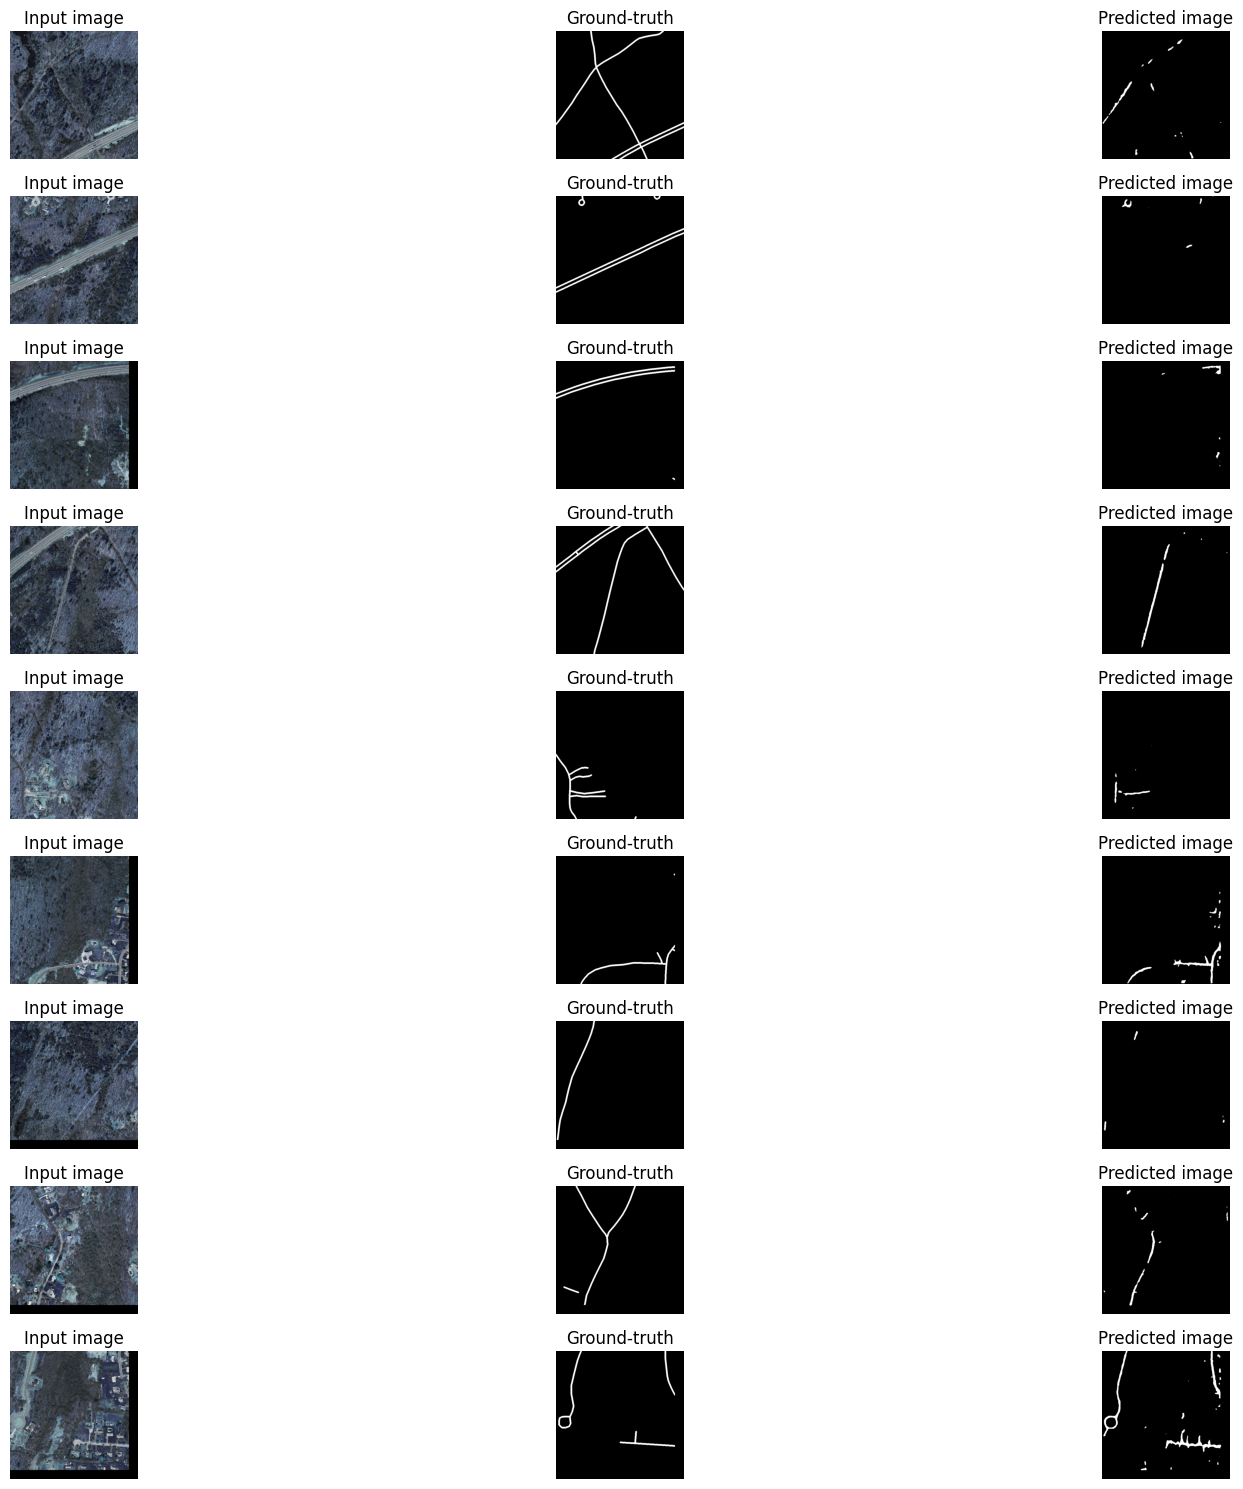

In [29]:
visualize_predictions(x_test, y_test, y_predicted, num_samples=9)

In [27]:
model.load_weights('morphUnet_road.h5')

In [28]:
y_predicted=[]
for i in range(len(x_test)):
    image= np.expand_dims(x_test[i], axis=0)

    y_pred = model.predict(image)
    y_pred=y_pred>0.5
    y_predicted.append(y_pred)



In [30]:
from sklearn.metrics import *
gt=(y_test.ravel()).astype('int')
pd=(np.array(y_predicted).ravel()).astype('int')
f1 = f1_score(gt,pd,average='macro')
kappa = cohen_kappa_score(gt,pd)
accuracy = accuracy_score(gt,pd)
jaccard = jaccard_score(gt,pd,average='macro')
precision = precision_score(gt,pd,average='macro')
recall = recall_score(gt,pd,average='macro')
print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


[0 1] [0 1]
F1 SCORE: 0.6766317277878076
Kappa: 0.3547189287182104
Accuracy: 0.9551508205007263
Jaccard Score: 0.5932301089685392
Precision: 0.733574709862294
Recall: 0.6439989933513516
